### Imports

In [1]:
import numpy as np, pandas as pd
import joblib, os
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("ticks")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing, classifiers, utils

### Uncertainty-Aware Fall Detection
The test set is not segmented. `X_test` is the full 20-minute signal and `y_test` contains the fall points for each signal.

#### With 5-fold Cross-validation and Multiphase

In [2]:
# Tabular models
kwargs = dict(
	window_size=14, cv=5,
	segment_test=False,
	multiphase=True,
    tolerance=160,
	model_type='tabular'
)
tab_metric_df, tab_aggr_df = classifiers.cross_validate(
	farseeing, **kwargs)
tab_metric_df['model_type'] = 'tabular'
tab_aggr_df['model_type'] = 'tabular'



-- fold 1, testing on (8 subjects) --
Train set: X: (2513, 1400), y: (2513,) ([ADLs, Falls]) [2399  114]
Test set: X: 34, y: 34
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 2, testing on (8 subjects) --
Train set: X: (1593, 1400), y: (1593,) ([ADLs, Falls]) [1521   72]
Test set: X: 46, y: 46
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 3, testing on (8 subjects) --
Train set: X: (1295, 1400), y: (1295,) ([ADLs, Falls]) [1234   61]
Test set: X: 17, y: 17
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 4, testing on (8 subjects) --
Train set: X: (1087, 1400), y: (1087,) ([ADLs, Falls]) [1042   45]
Test set: X: 18, y: 18
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 5, testing on (8 subjects)

In [3]:
# ts models
kwargs['model_type']='ts'
ts_metric_df, ts_aggr_df = classifiers.cross_validate(
	farseeing, **kwargs)
ts_metric_df['model_type'] = 'ts'
ts_aggr_df['model_type'] = 'ts'



-- fold 1, testing on (8 subjects) --
Train set: X: (2513, 1400), y: (2513,) ([ADLs, Falls]) [2399  114]
Test set: X: 34, y: 34
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 2, testing on (8 subjects) --
Train set: X: (1593, 1400), y: (1593,) ([ADLs, Falls]) [1521   72]
Test set: X: 46, y: 46
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 3, testing on (8 subjects) --
Train set: X: (1295, 1400), y: (1295,) ([ADLs, Falls]) [1234   61]
Test set: X: 17, y: 17
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 4, testing on (8 subjects) --
Train set: X: (1087, 1400), y: (1087,) ([ADLs, Falls]) [1042   45]
Test set: X: 18, y: 18
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 5, testing on (8 subjects) --
Train set: X: (782, 1400), y: (782,) ([ADLs, Falls]) [757  25]
Test set: X: 29, y: 29
⏳ TRAINING Rocket. Cat

In [5]:
# save all dfs
all_metric_df = pd.concat([tab_metric_df, ts_metric_df], ignore_index=True)
all_aggr_df = pd.concat([tab_aggr_df, ts_aggr_df], ignore_index=True)
all_metric_df.to_csv('results/farseeing_all_metric_df_w14_t160.csv', index=False)
all_aggr_df.to_csv('results/farseeing_all_aggr_df_w14_t160.csv', index=False)

In [6]:
load_path = 'results/farseeing_all_metric_df_w14_t160.csv'
all_metric_df = pd.read_csv(load_path)
tab_metric_df = all_metric_df[all_metric_df['model_type'] == 'tabular']
ts_metric_df = all_metric_df[all_metric_df['model_type'] == 'ts']

In [ ]:
tab_metric_df.replace({'model': {'Ensemble': 'Tabular Ensemble'}}, inplace=True)
ts_metric_df.replace({'model': {'Ensemble': 'TS Ensemble'}}, inplace=True)
all_metric_df = pd.concat([tab_metric_df, ts_metric_df], ignore_index=True)

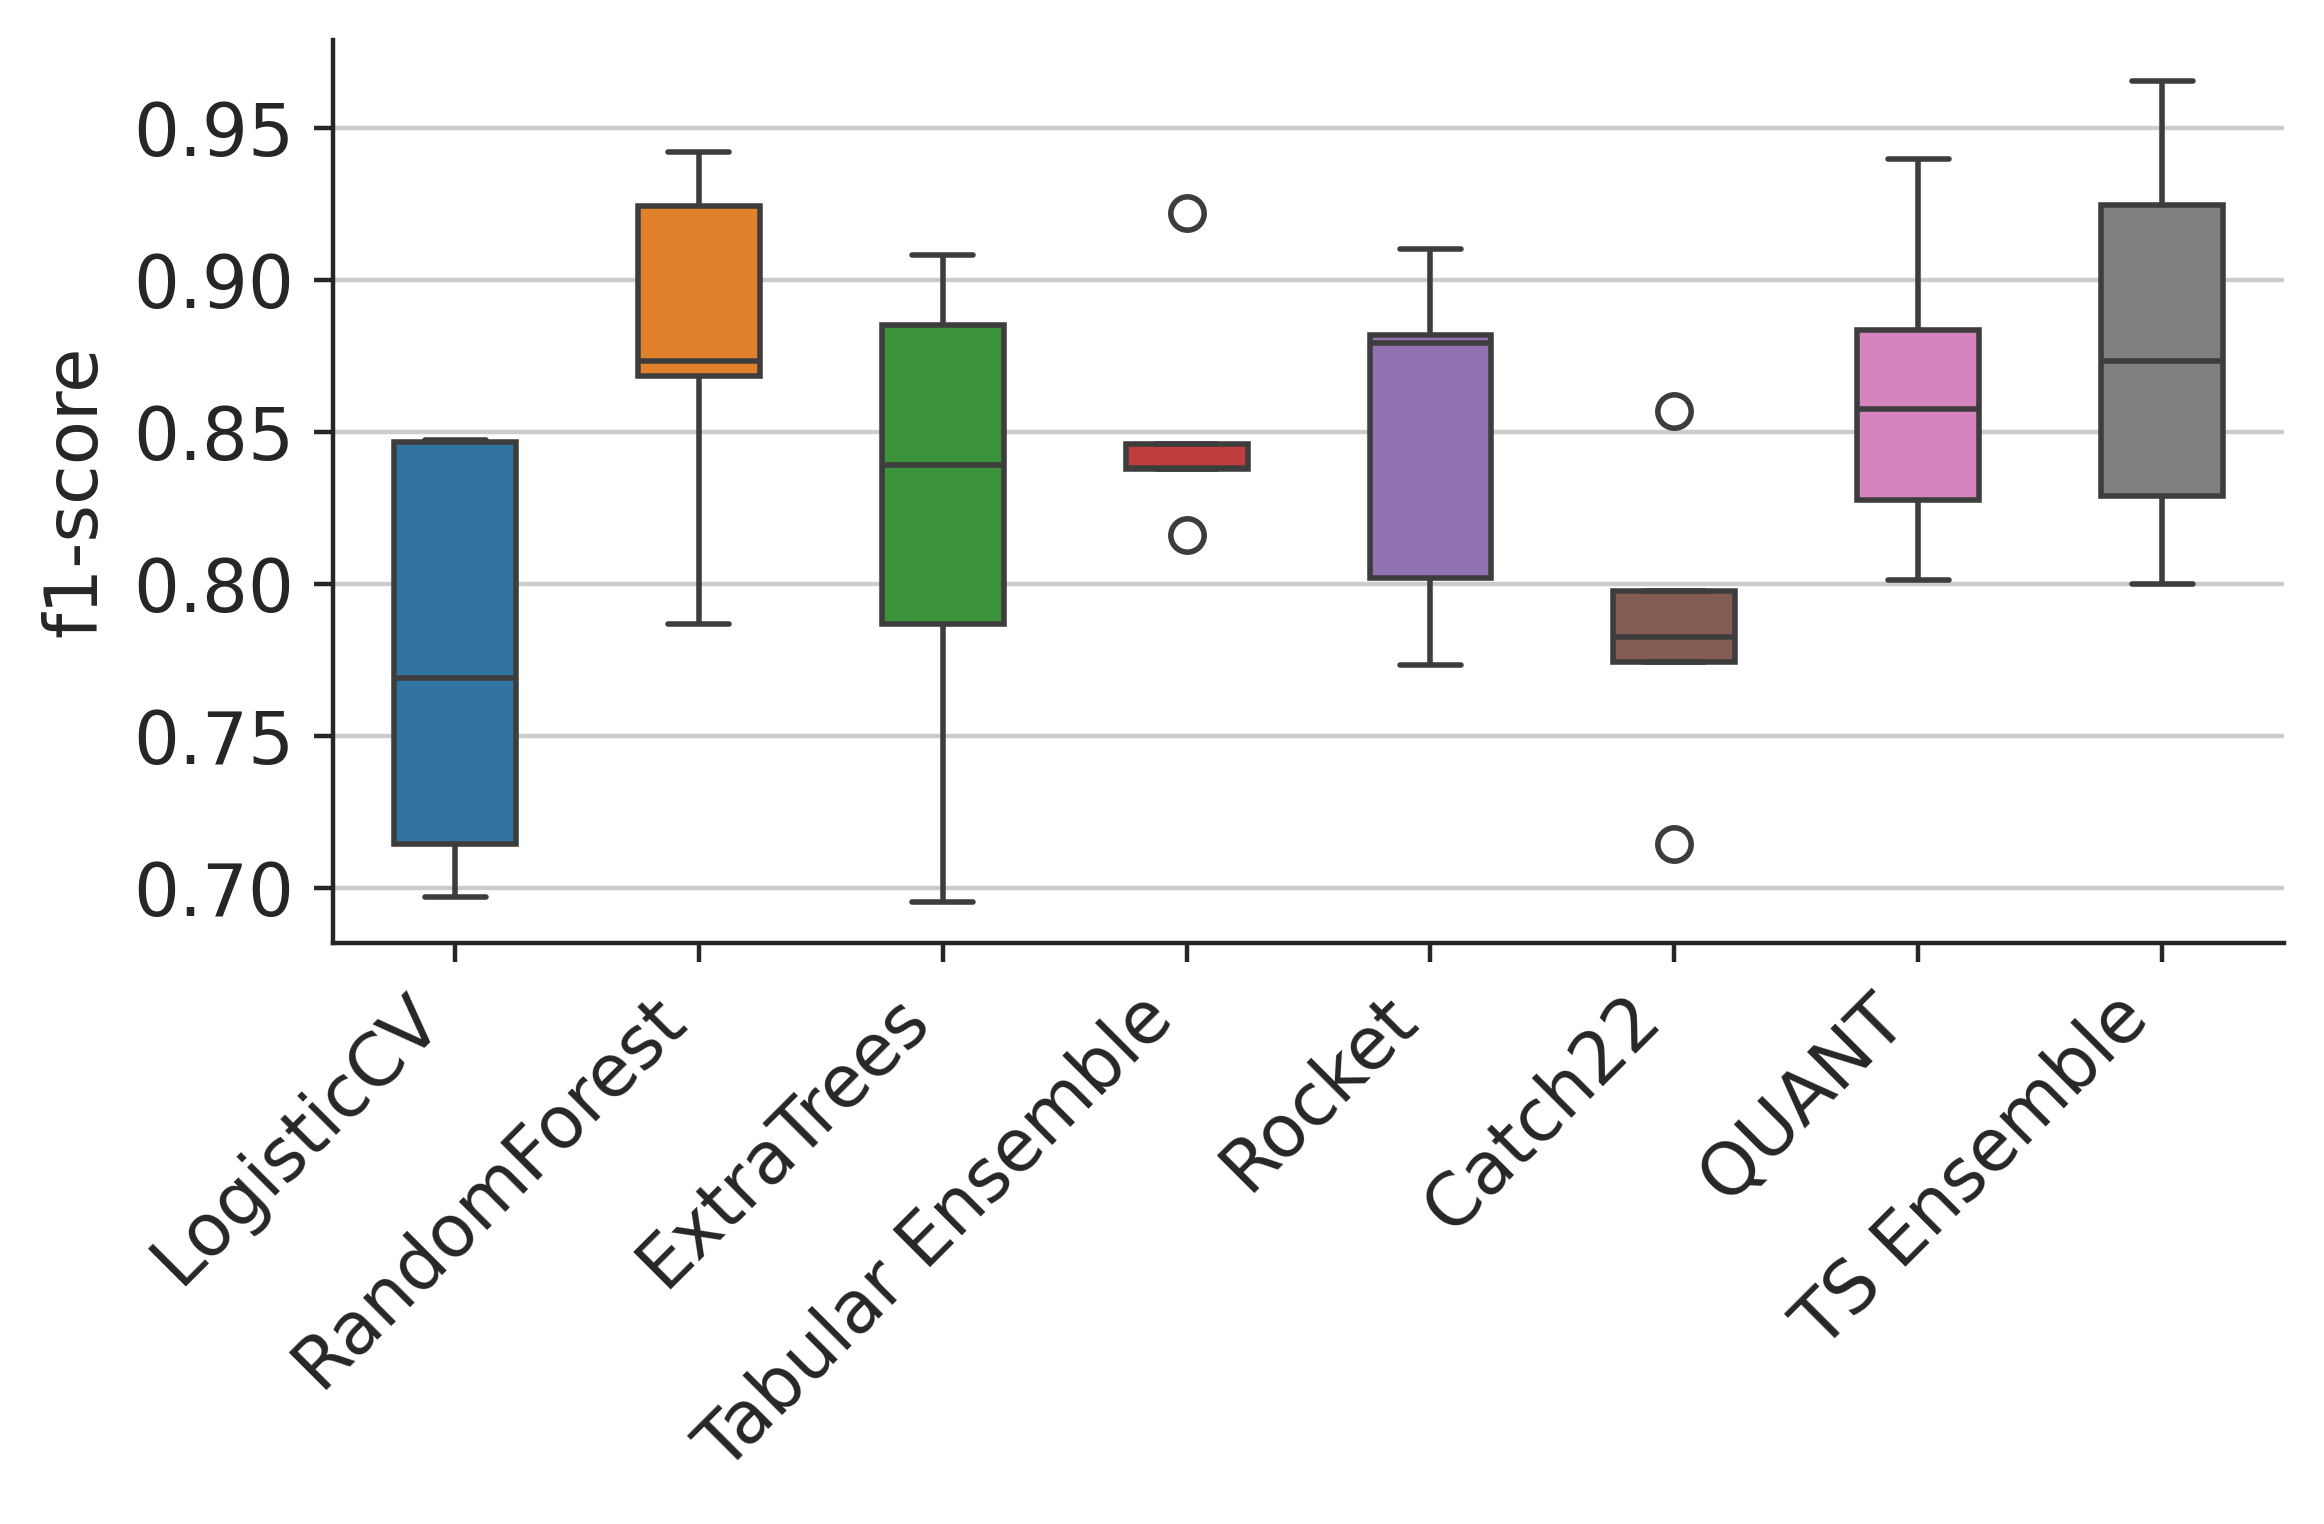

In [8]:
utils.summary_visualization([all_metric_df], name='all_models')

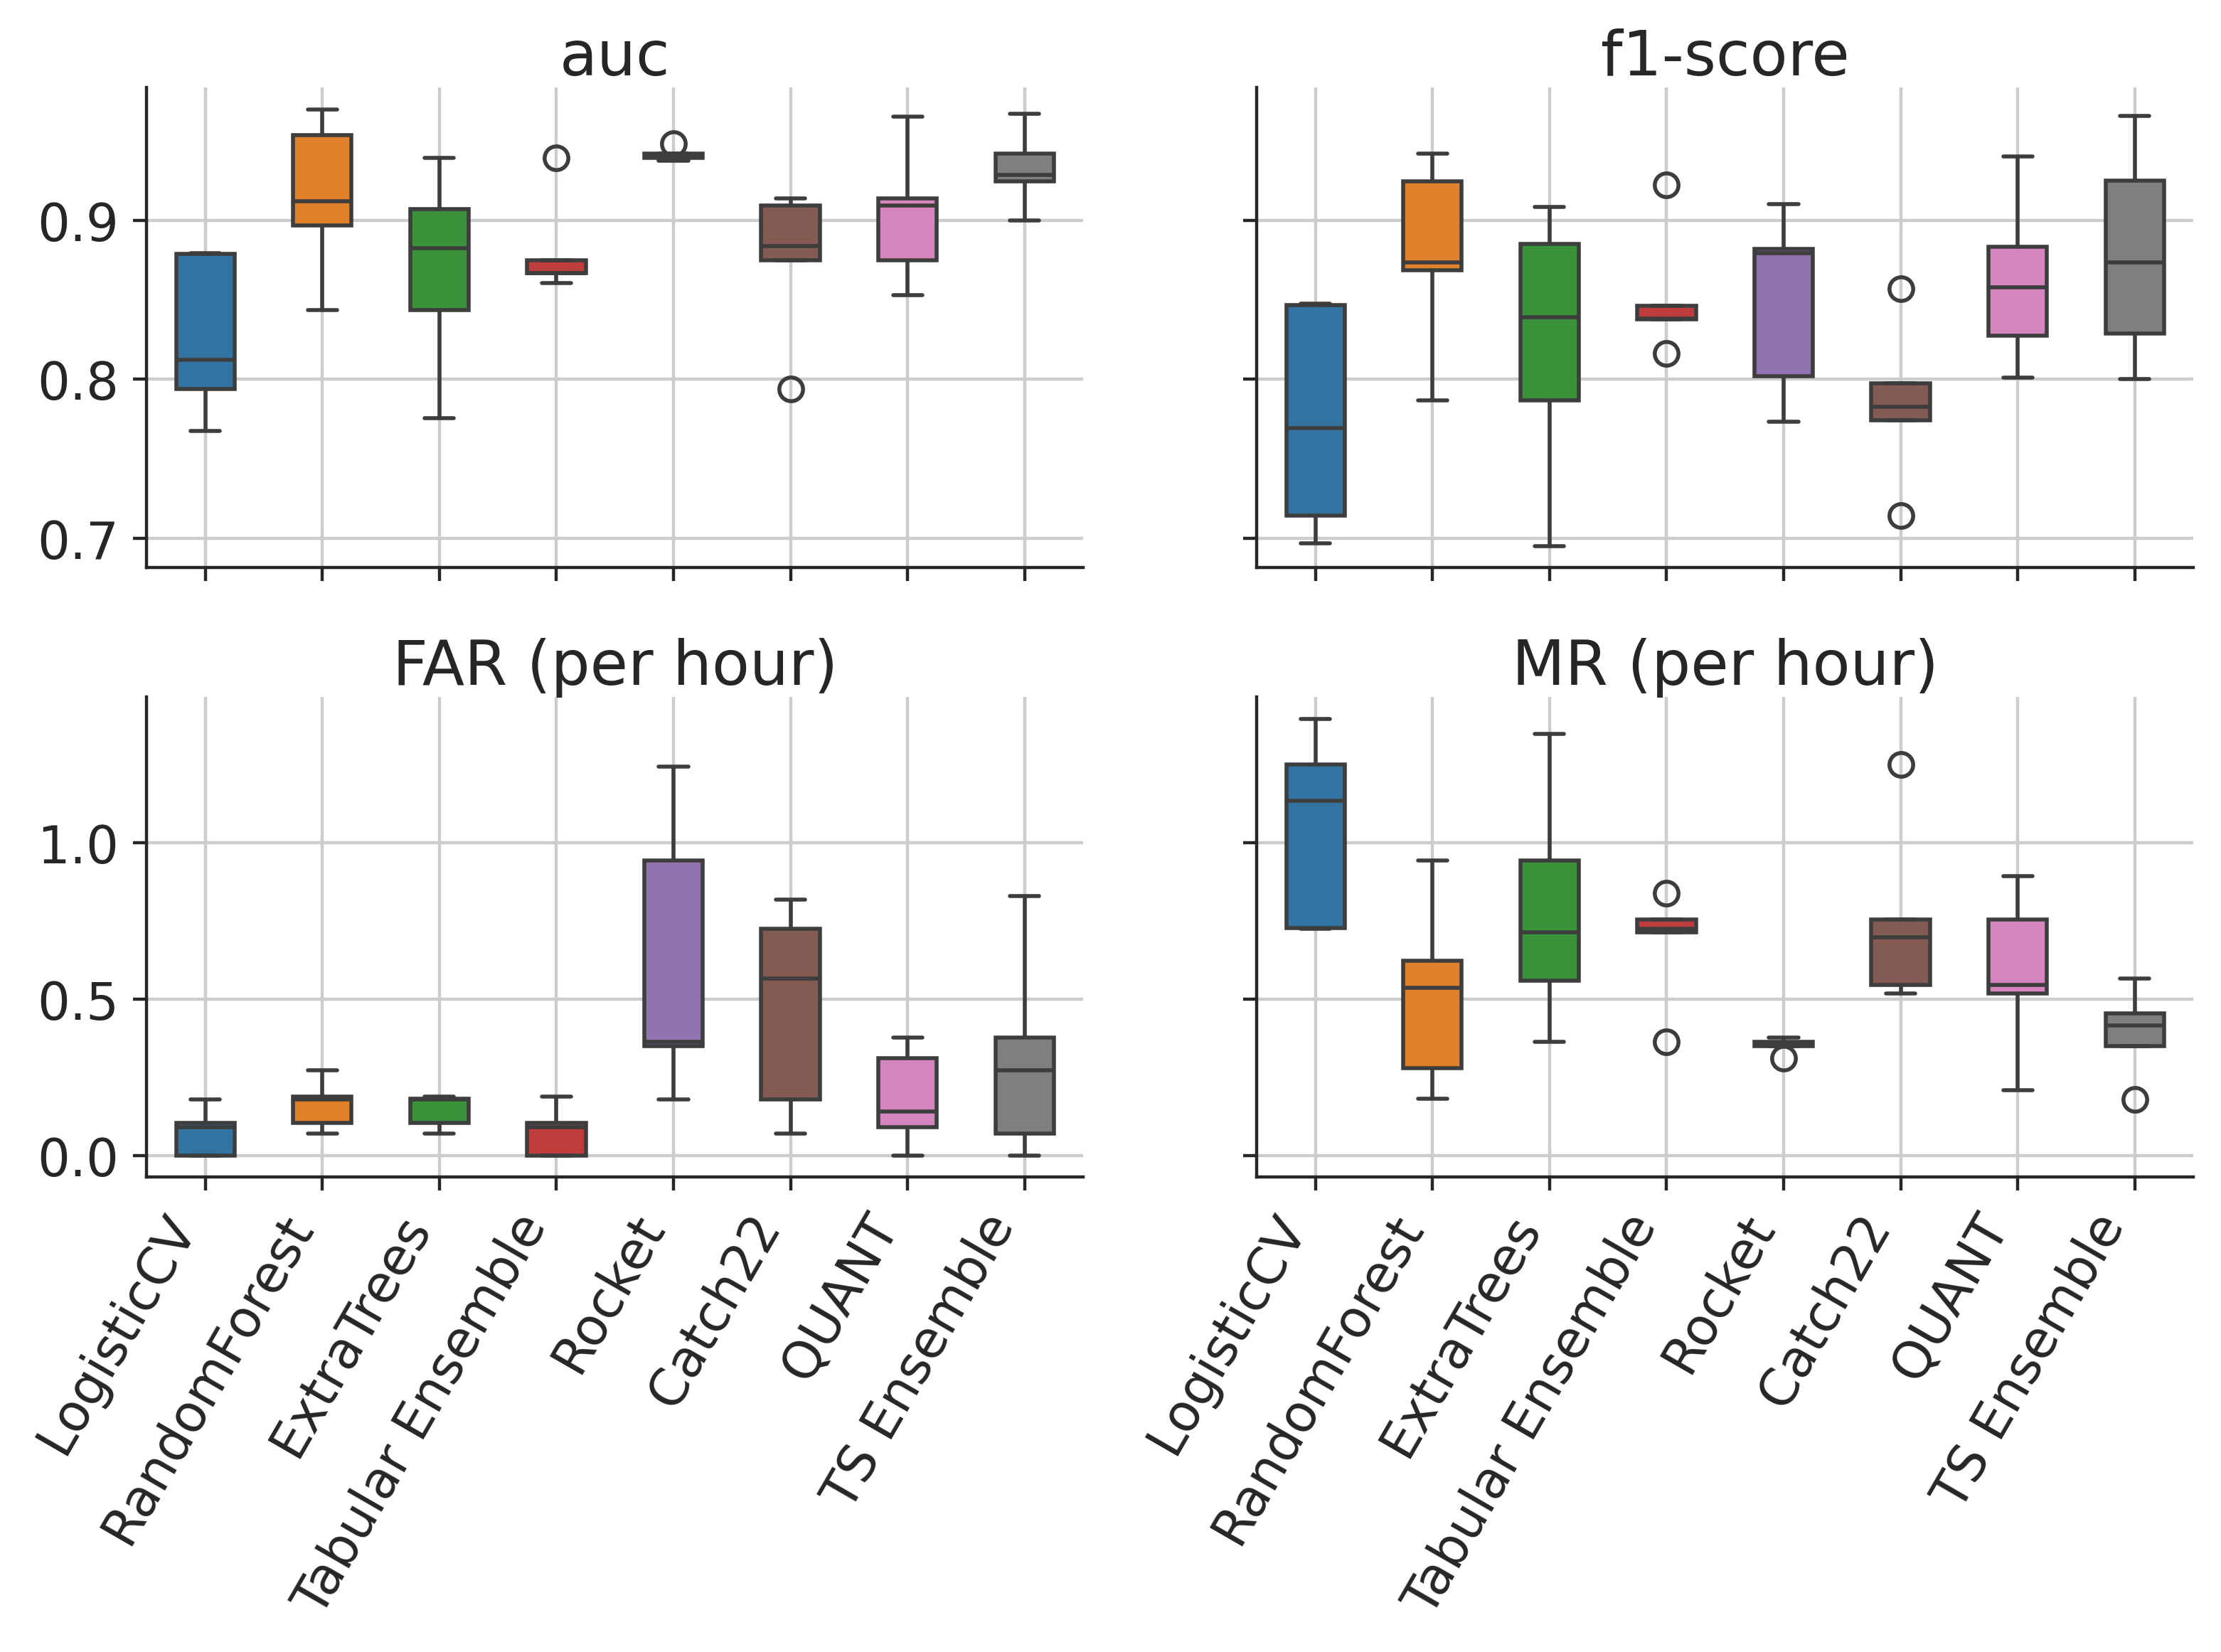

In [9]:
metrics = ['auc', 'f1-score',
           'false alarm rate', 'miss rate']
utils.visualise_all_metrics(all_metric_df, metrics=metrics)

#### Cost-sensitive

In [10]:
kwargs = dict(
	window_size=14,
    multiphase=True,
	segment_test=False,
	tune_threshold=True)
dataset = utils.train_test_subjects_split(
    farseeing, **kwargs)

Train set: X: (3292, 1400), y: (3292,)        ([ADLs, Falls]) [3180  112]
Test set: X: 34, y: 34


In [11]:
metrics_df = []
kwargs['ensemble'] = False
kwargs['models_subset'] = None
for t in [False, True]:
    print(f'Tuning threshold: {t}')
    kwargs['tune_threshold'] = t
    for model_type in ['tabular', 'ts']:
        kwargs['model_type'] = model_type
        df = classifiers.run_models(*dataset, **kwargs)
        df['threshold'] = 'auto' if t else 'default'
        df['model_type'] = model_type
        metrics_df.append(df)
metrics_df = pd.concat(metrics_df, ignore_index=True)
metrics_df.to_csv('results/farseeing_tune_threshold_w14_t160.csv', index=False)

Tuning threshold: False
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. . ✅
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
Tuning threshold: True
⏳ TRAINING LogisticCV. Tuning threshold...
thresh: 0.1919194806382754 RandomForest. Tuning threshold...
thresh: 0.46545454545454545 ExtraTrees. Tuning threshold...
thresh: 0.43434343434343436 ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.4797979797979798 QUANT. Tuning threshold...
thresh: 0.5454545454545455 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅


In [12]:
metrics_df.sort_values(by=['model'])

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,delay,g,threshold,model_type
4,Catch22,14,26.654127,0.863636,0.80,0.727273,0.999998,0.761905,0.545450,0.818175,3.464242,0.001,default,ts
10,Catch22,14,29.229741,0.878787,0.81,0.757576,0.999998,0.782911,0.545450,0.727267,2.736970,0.001,auto,ts
2,ExtraTrees,14,0.554712,0.939394,0.94,0.878788,0.999999,0.908364,0.181817,0.363633,1.909091,0.001,default,tabular
8,ExtraTrees,14,0.630179,0.954545,0.91,0.909091,0.999999,0.909545,0.272725,0.272725,1.242424,0.001,auto,tabular
0,LogisticCV,14,0.161152,0.893939,0.81,0.787879,0.999998,0.798786,0.545450,0.636358,3.848485,0.001,default,tabular
6,LogisticCV,14,0.163576,0.969696,0.76,0.939394,0.999997,0.840228,0.909083,0.181817,-2.424242,0.001,auto,tabular
5,QUANT,14,6.041985,0.954545,0.86,0.909091,0.999999,0.883864,0.454542,0.272725,0.797576,0.001,default,ts
11,QUANT,14,6.036480,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,0.858182,0.001,auto,ts
1,RandomForest,14,0.247874,0.984848,0.89,0.969697,0.999999,0.928141,0.363633,0.090908,0.888485,0.001,default,tabular
7,RandomForest,14,0.234822,0.969696,0.78,0.939394,0.999998,0.852309,0.818175,0.181817,1.524848,0.001,auto,tabular


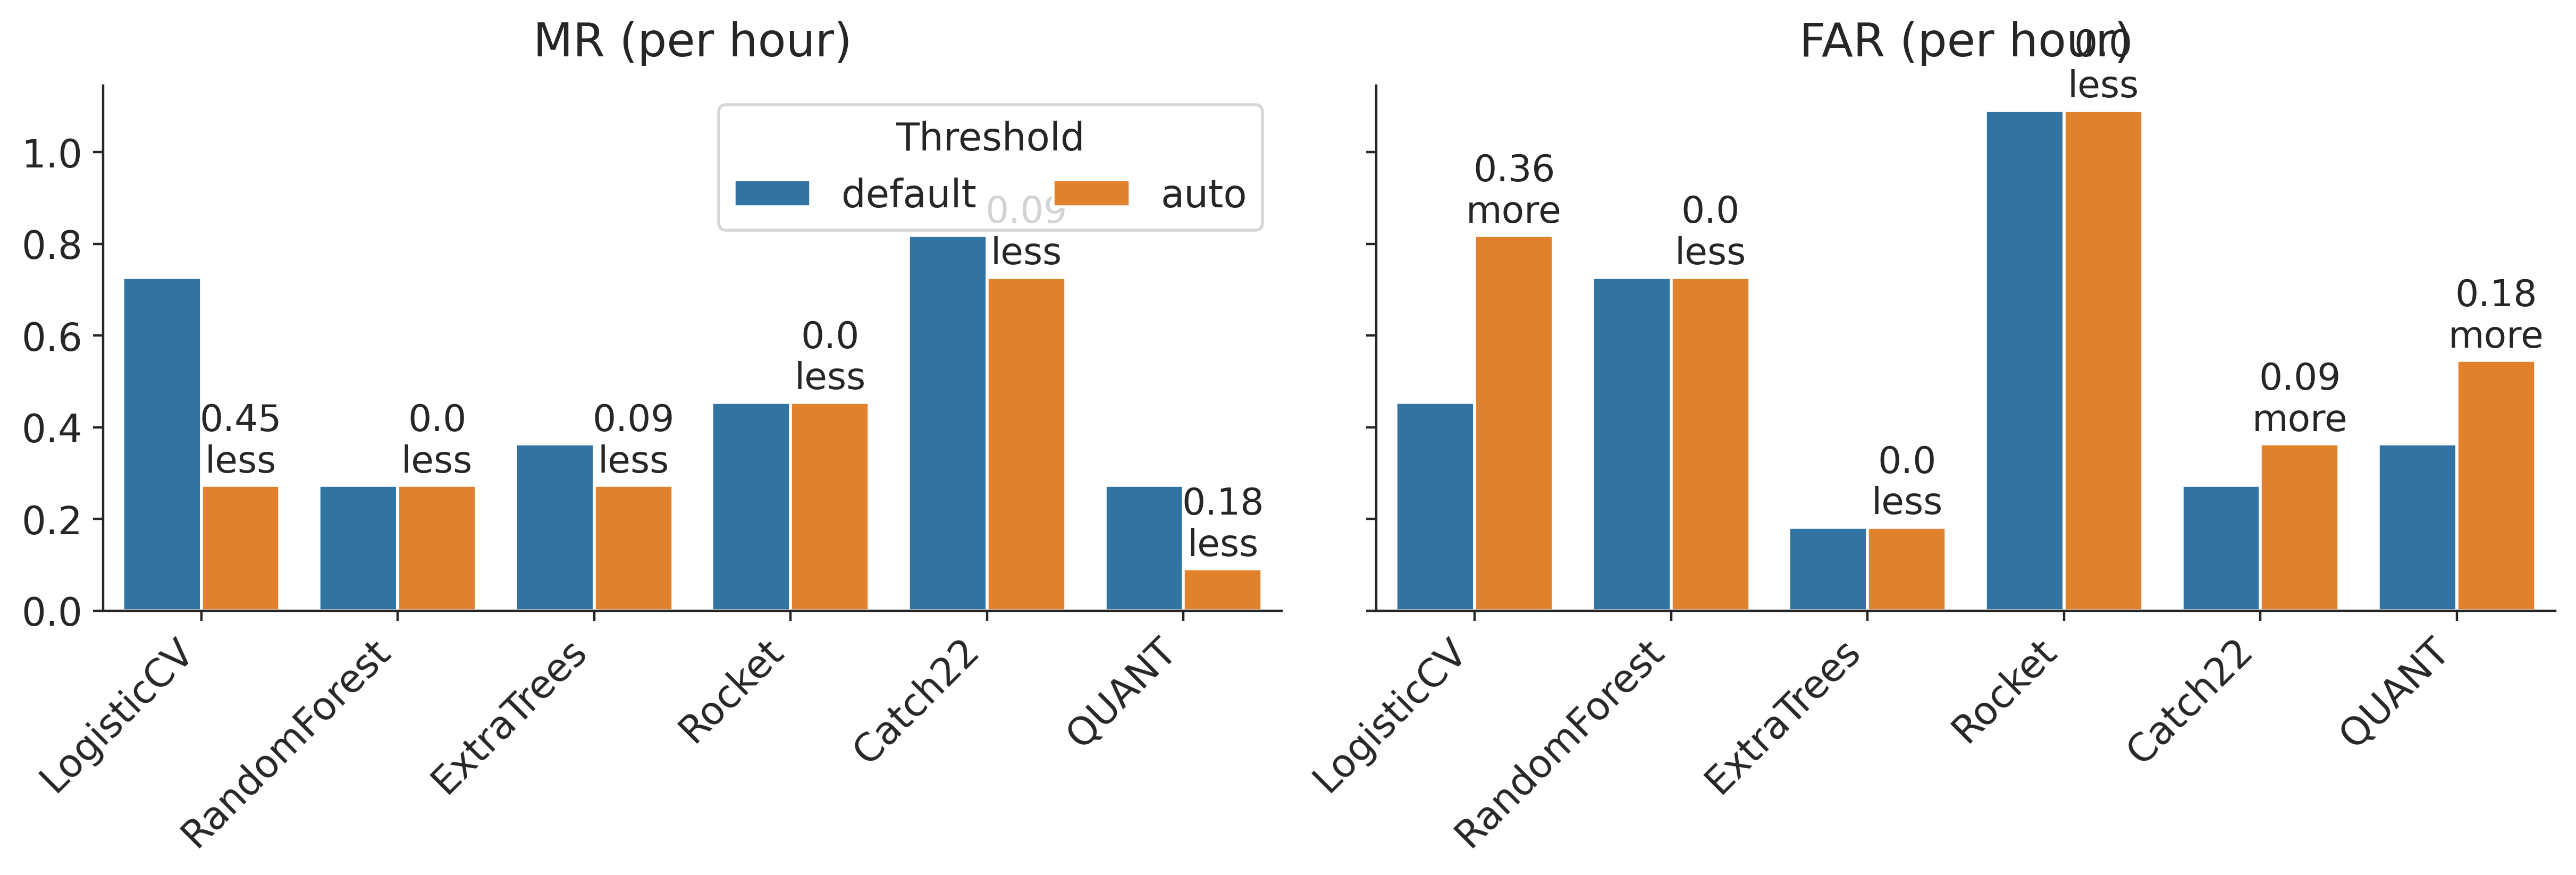

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400,
					   sharey=True, layout='constrained')
for i, m in enumerate(['miss rate', 'false alarm rate']):
	sns.barplot(data=metrics_df, x='model', y=m, hue='threshold',
			 ax=ax[i], palette='tab10')
	labels1 = [x for x in ax[i].containers[0].datavalues] # Round up container[0] values
	labels2 = [x for x in ax[i].containers[1].datavalues] # Round up container[1] values
	improvements = [np.round(b-a,2) for a, b in zip(labels1, labels2)] # Calculate improvements
	lbls = [f'{i}\nmore' if i > 0 else f'{abs(i)}\nless' for i in improvements] # Annotate using rounded values
	# Annotate using rounded values
	ax[i].bar_label(ax[i].containers[1], labels=lbls, fontsize=12.5, padding=2)
	ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
	m = 'FAR (per hour)' if m == 'false alarm rate' else m
	m = 'MR (per hour)' if m == 'miss rate' else m
	ax[i].set_title(m, pad=10)
	ax[i].set_xlabel('')
	ax[i].set_ylabel('')
	# only show legend for the last plot
	if i > 0:
		ax[i].get_legend().remove()
	else:
		ax[i].legend(title='Threshold', ncols=2)
sns.despine()
plt.savefig('figs/barplot_tune_threshold_7sec.pdf',
			dpi=400, bbox_inches='tight')
plt.show()

#### Cost sensitivity analysis

In [28]:
kwargs['ensemble'] = False
kwargs['models_subset'] = ['QUANT']
kwargs['tune_threshold'] = False
dataset = utils.train_test_subjects_split(farseeing, **kwargs)
X_train, X_test, y_train, y_test = dataset
trained_quant, thresh = classifiers.train_models(X_train, y_train, **kwargs)

Train set: X: (3426, 700), y: (3426,)        ([ADLs, Falls]) [3314  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅


In [33]:
# save the trained models

joblib.dump({'models': trained_quant,
             'thresholds': thresh},
             'models/farseeing_trained_quant_7.joblib')

['models/farseeing_trained_quant_7.joblib']

In [37]:
kwargs['saved_models'] = 'models/farseeing_trained_quant_7.joblib'
kwargs['ensemble'] = False
tune_df = []
tolerances = np.arange(0, 300, 20)
for t in tolerances:
	print(f'Testing at tolerance of {t} secs')
	kwargs['tolerance'] = t
	df = classifiers.run_models(*dataset, **kwargs)
	df['tolerance'] = t
	tune_df.append(df)
tune_df = pd.concat(tune_df, ignore_index=True)
tune_df.to_csv('results/quant_tolerance_analysis.csv', index=False)

Testing at tolerance of 0 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 20 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 40 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 60 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 80 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 100 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 120 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 140 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 160 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 180 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 200 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 220 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 240 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 260 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 280 secs
Loaded models
🔍 TESTI

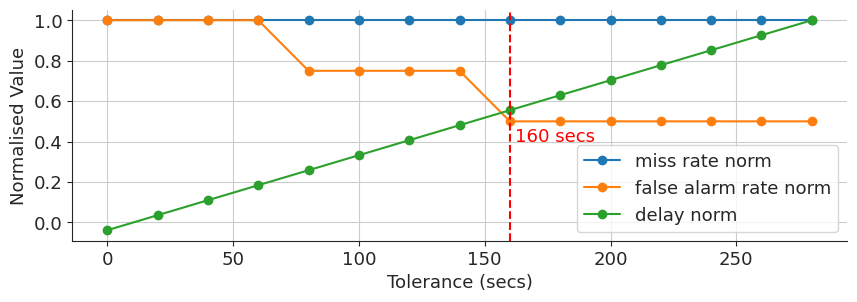

In [62]:
# normalise miss rate, false alarm rate and delay
tune_df['miss rate norm'] = tune_df['miss rate'] / tune_df['miss rate'].max()
tune_df['false alarm rate norm'] = tune_df['false alarm rate'] / tune_df['false alarm rate'].max()
tune_df['delay norm'] = tune_df['delay'] / tune_df['delay'].max()
tune_df.plot(x='tolerance', y=['miss rate norm', 'false alarm rate norm', 'delay norm'],
					  kind='line', marker='o', figsize=(10, 3), grid=True)
# draw a vertical line and annotate where miss rate norm == delay norm
intersection = tune_df.loc[tune_df['false alarm rate norm'].sub(tune_df['delay norm']).abs().idxmin()]['tolerance']
plt.axvline(intersection, color='r', linestyle='--')
plt.annotate(f'{intersection} secs',
			 (intersection+2, 0.4), color='r')
plt.xlabel('Tolerance (secs)')
plt.ylabel('Normalised Value')
plt.legend()
sns.despine()
plt.savefig('figs/tolerance_analysis.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [43]:
tune_df

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,delay,g,tolerance,mr norm,far norm,delay norm
0,QUANT,7,4.205494,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,-0.939394,0.001,0,1.0,1.00,-0.038319
1,QUANT,7,4.204310,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,0.878788,0.001,20,1.0,1.00,0.035847
2,QUANT,7,4.196430,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,2.696970,0.001,40,1.0,1.00,0.110012
3,QUANT,7,4.200871,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,4.515152,0.001,60,1.0,1.00,0.184178
4,QUANT,7,4.205597,0.954545,0.91,0.909091,0.999999,0.909545,0.272725,0.272725,6.333333,0.001,80,1.0,0.75,0.258344
5,QUANT,7,4.200227,0.954545,0.91,0.909091,0.999999,0.909545,0.272725,0.272725,8.151515,0.001,100,1.0,0.75,0.332509
6,QUANT,7,4.196657,0.954545,0.91,0.909091,0.999999,0.909545,0.272725,0.272725,9.969697,0.001,120,1.0,0.75,0.406675
7,QUANT,7,4.203201,0.954545,0.91,0.909091,0.999999,0.909545,0.272725,0.272725,11.787879,0.001,140,1.0,0.75,0.480841
8,QUANT,7,4.200890,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,13.606061,0.001,160,1.0,0.50,0.555006
9,QUANT,7,4.191219,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,15.424242,0.001,180,1.0,0.50,0.629172


In [184]:
quant_metrics_df

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,g,fn_factor
0,ExtraTrees,7,0.464314,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,2
1,QUANT,7,4.231537,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,2
2,ExtraTrees,7,0.461912,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,4
3,QUANT,7,4.247642,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,4
4,ExtraTrees,7,0.482233,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,0.001,6
5,QUANT,7,4.256110,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,6
6,ExtraTrees,7,0.462802,0.969696,0.76,0.939394,0.999997,0.840228,0.909083,0.181817,0.001,8
7,QUANT,7,4.250642,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,8
8,ExtraTrees,7,0.478242,0.969696,0.76,0.939394,0.999997,0.840228,0.909083,0.181817,0.001,10
9,QUANT,7,4.221790,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,0.001,10


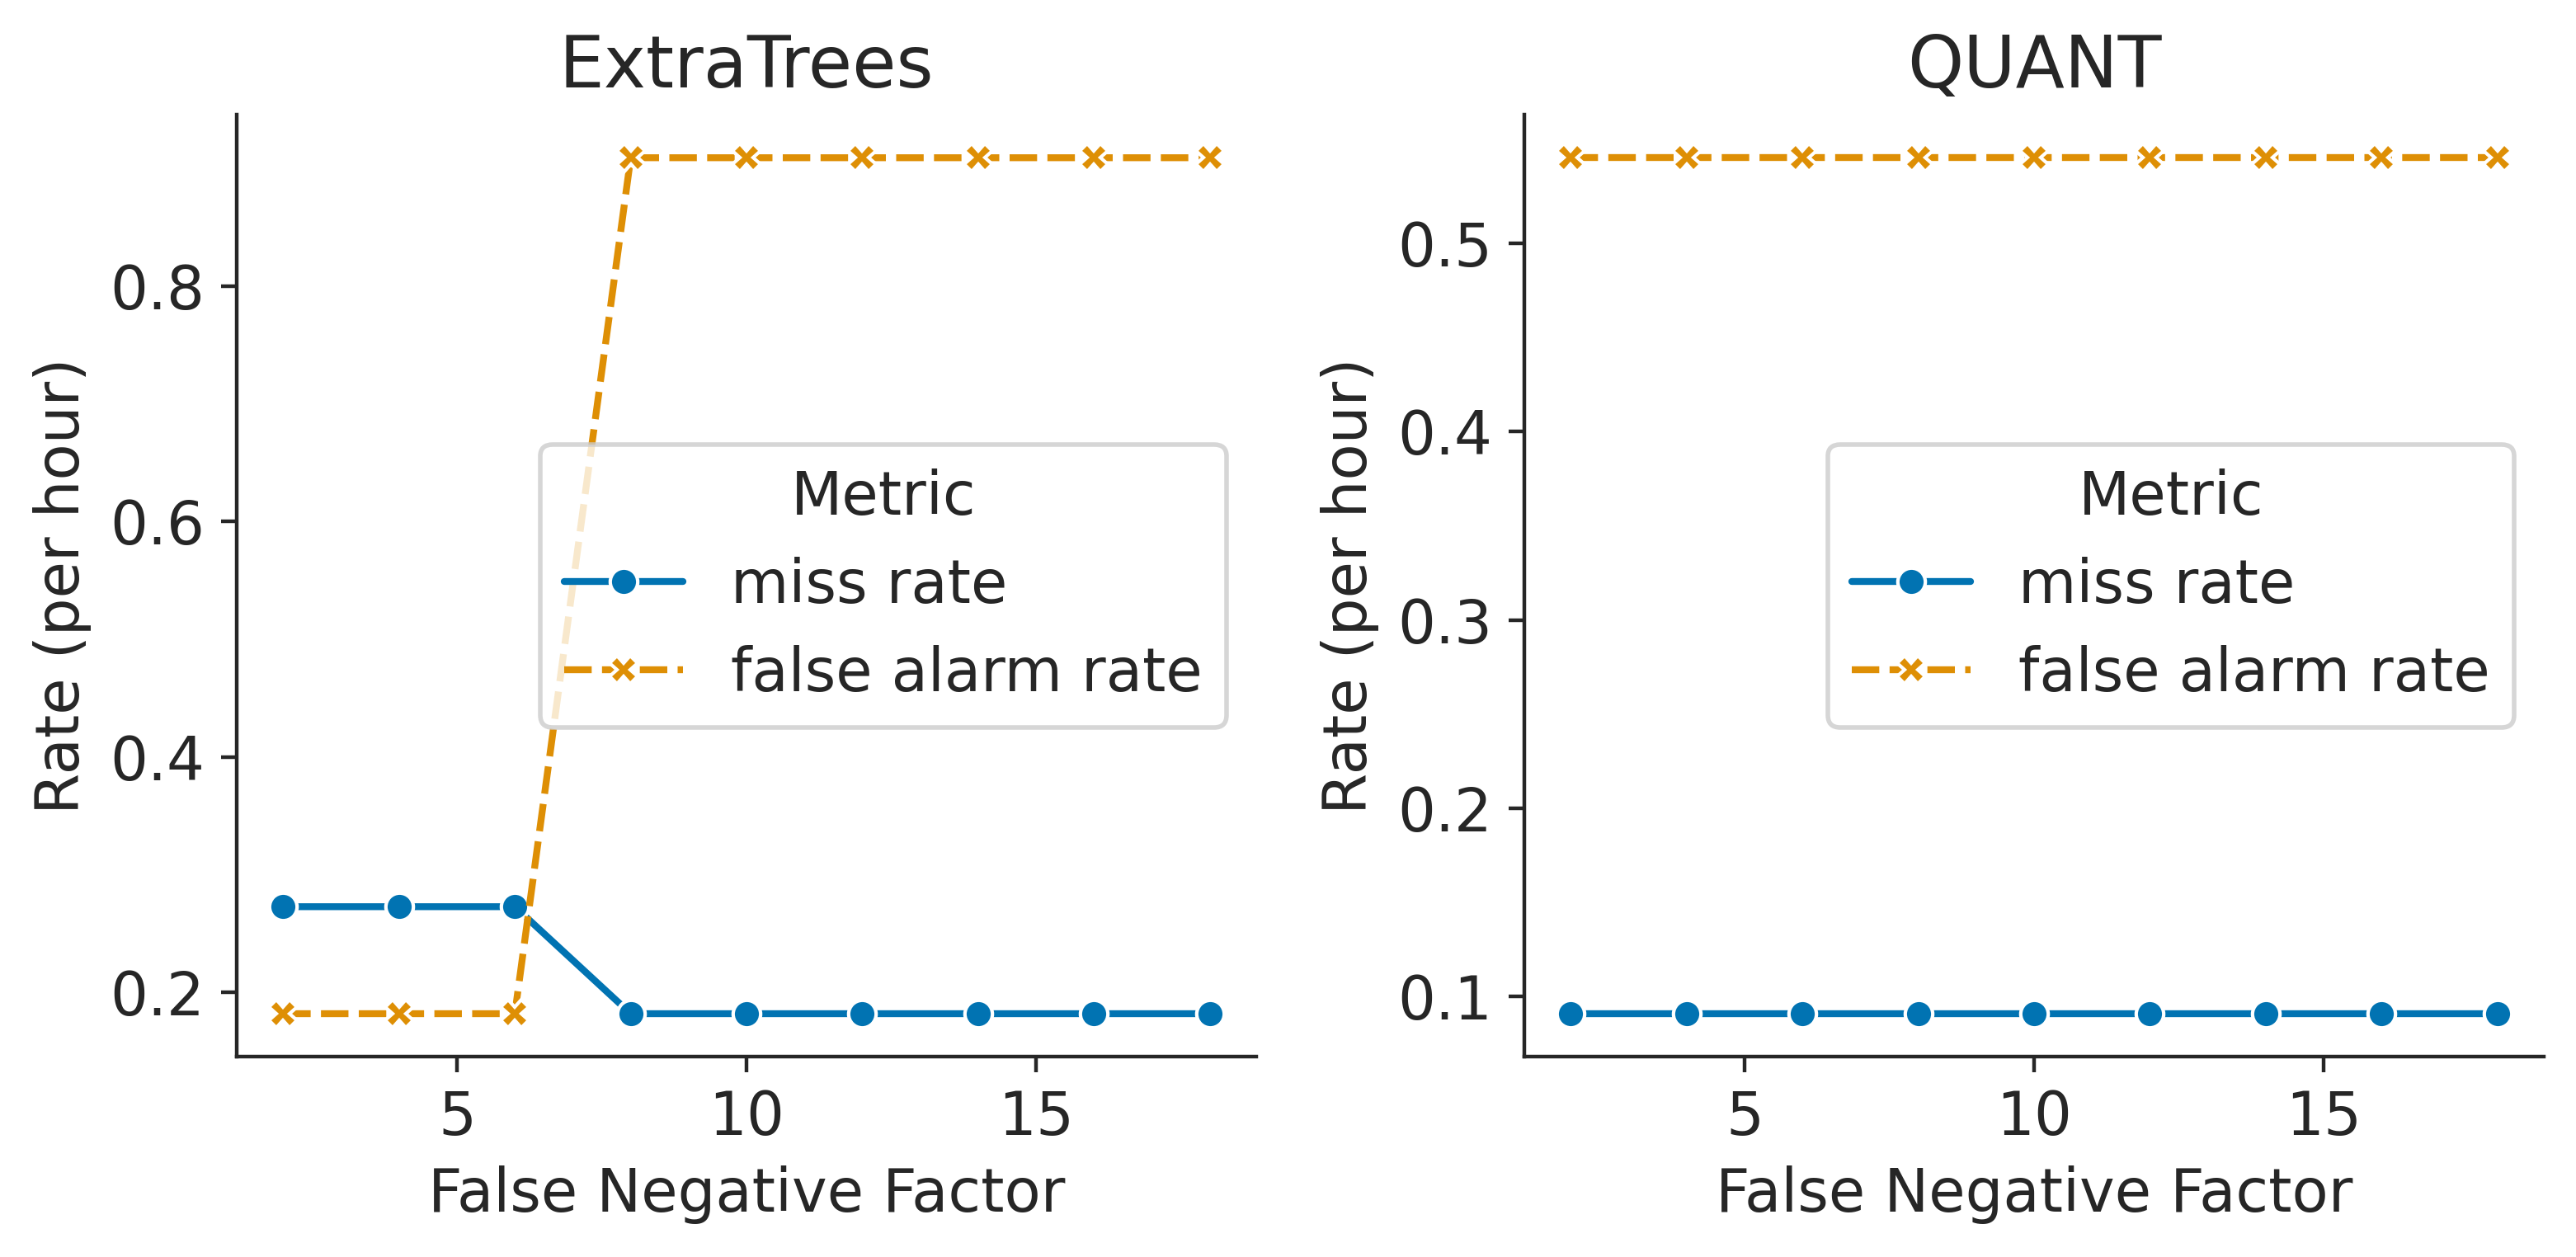

In [183]:
long_sens_df = quant_metrics_df.melt(id_vars=['model', 'fn_factor'],
									  value_vars=['miss rate', 'false alarm rate'],
									  var_name='metric', value_name='rate')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=400)
for i, model in enumerate(long_sens_df['model'].unique()):
	sns.lineplot(data=long_sens_df[long_sens_df['model'] == model],
				 x='fn_factor', y='rate', hue='metric', style='metric',
				 markers=True, ax=ax[i])
	ax[i].set_title(model)
	ax[i].set_xlabel('False Negative Factor')
	ax[i].set_ylabel('Rate (per hour)')
	ax[i].legend(title='Metric')
sns.despine()
plt.tight_layout()
# plt.savefig('figs/sensitivity_analysis_long.pdf', dpi=400, bbox_inches='tight')
plt.show()